In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Path to your data
data_dir = r"C:\Users\Lenovo\Desktop\classes_equal"

# Set image size and batch size
img_size = (224, 224)
batch_size = 30
seed = 123

# Load dataset with an 80/10/10 split
full_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',# model isome the labes kweny respective folder
    label_mode='categorical',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='training'
)

val_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='validation'
)

# Now split validation again into val and test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Optional: Performance boost
AUTOTUNE = tf.data.AUTOTUNE
train_ds = full_ds.prefetch(buffer_size=AUTOTUNE)#prefetching allows the data pipeline to prepare the nextbatch of data while the current batch is being processed by the model
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 420 files belonging to 3 classes.
Using 336 files for training.
Found 420 files belonging to 3 classes.
Using 84 files for validation.


NORMALIZATION

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


input_shape = (224, 224, 3) #input shape


base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape) #loading the model excluding the top
base_model.trainable = False  # Freeze for transfer learning

# custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Compiling the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
# Reducing the Learning rate
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[lr_reduce, early_stop]
)


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2961 - loss: 1.8137 - val_accuracy: 0.4630 - val_loss: 1.1275 - learning_rate: 1.0000e-04
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5188 - loss: 1.2239 - val_accuracy: 0.4815 - val_loss: 1.0933 - learning_rate: 1.0000e-04
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5846 - loss: 0.9464 - val_accuracy: 0.5000 - val_loss: 0.9851 - learning_rate: 1.0000e-04
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6527 - loss: 0.8176 - val_accuracy: 0.6111 - val_loss: 0.9068 - learning_rate: 1.0000e-04
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7114 - loss: 0.7567 - val_accuracy: 0.6667 - val_loss: 0.8435 - learning_rate: 1.0000e-04
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7634 - loss: 0.5974 - val_accuracy: 0.6481 - val_loss: 0.7572 - learning_rate: 1.0000e-04
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7105 - loss:

In [21]:
# Unfreeze top layers for fine-tuning
base_model.trainable = True

# Fine-tune last 30 layers (you can adjust this)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile with lower learning rate
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune training
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[lr_reduce, early_stop]
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6645 - loss: 0.7326 - val_accuracy: 0.7778 - val_loss: 0.4914 - learning_rate: 1.0000e-05
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6749 - loss: 0.7818 - val_accuracy: 0.7222 - val_loss: 0.5709 - learning_rate: 1.0000e-05
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7371 - loss: 0.7389 - val_accuracy: 0.7963 - val_loss: 0.4414 - learning_rate: 1.0000e-05
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6972 - loss: 0.7051 - val_accuracy: 0.7593 - val_loss: 0.5116 - learning_rate: 1.0000e-05
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7026 - loss: 0.6618 - val_accuracy: 0.7222 - val_loss: 0.5176 - learning_rate: 1.0000e-05
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7178 - loss: 0.6803
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7177 - loss: 0.68

In [30]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true and predicted labels
y_true_labels = []
y_pred_labels = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true_labels.extend(np.argmax(labels.numpy(), axis=1))   # convert one-hot to class index
    y_pred_labels.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [31]:
# Basic evaluation (loss & accuracy)
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 0.4927
Test Accuracy: 80.00%
Test Loss: 0.4927


Note: you may need to restart the kernel to use updated packages.


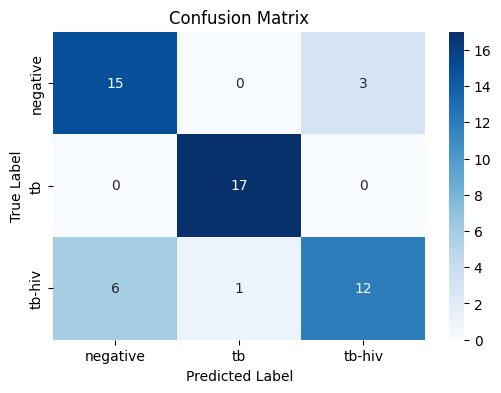

In [33]:
%pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels
y_true = np.array(y_true_labels)
y_pred = np.array(y_pred_labels)

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


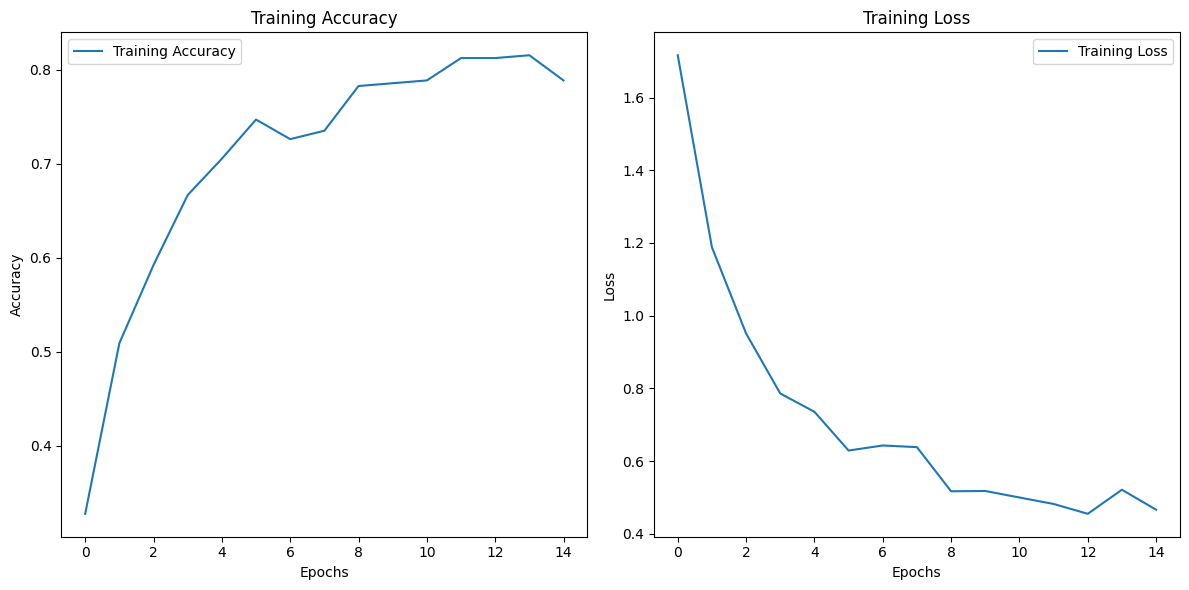

In [34]:

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()